In [107]:
# from google.colab import drive

# drive.mount("/content/drive")

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
TEST_IMG_PATH = "../dataset/bootcamp/test/images"
TEST_MASK_PATH = "../dataset/bootcamp/test/annotations"

EDA_DS_PATH = "../dataset/bootcamp/train"
EDA_TRAIN_LABELS = os.path.join(EDA_DS_PATH, "train_labels.csv")
EDA_TRAIN_FILES = os.path.join(EDA_DS_PATH, "train_files.csv")
EDA_VAL_FILES = os.path.join(EDA_DS_PATH, "val_files.csv")

MODEL_PATH = "../models/UNet"
MODEL_PATH_FCN8S = "../models/FCN8s"

In [3]:
# use validation images for inference test
labels_df = pd.read_csv(EDA_TRAIN_LABELS)

image_files = os.listdir(TEST_IMG_PATH)
mask_files = os.listdir(TEST_MASK_PATH)

test_files = [x for x in image_files if x in mask_files]

print(f"Test Files: {len(test_files)}, Image: {len(image_files)}, Mask: {len(mask_files)}")

print(labels_df)

Test Files: 101, Image: 101, Mask: 101
    class         label
0       0           sky
1       1      building
2       2          pole
3       3          road
4       4      sidewalk
5       5    vegetation
6       6  traffic sign
7       7         fence
8       8       vehicle
9       9        person
10     10         rider
11     11          void


In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def inference(batch_tensor, model, device='cuda'):
    """Proper batch inference function that handles all cases"""
    with torch.no_grad():
        # Ensure correct input dimensions
        if batch_tensor.dim() == 3:  # Single image (C,H,W)
            batch_tensor = batch_tensor.unsqueeze(0)  # Add batch dim
        elif batch_tensor.dim() != 4:  # Not standard 4D input
            raise ValueError(f"Expected 3D or 4D input, got {batch_tensor.dim()}D")
            
        batch_tensor = batch_tensor.to(device)
        logits = model(batch_tensor)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
    return logits, probs, preds
    
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_results(images, preds, masks, labels_df):
    """Visualize batch results"""
    n_classes = len(labels_df)
    legend_colors = [plt.cm.nipy_spectral(i / (n_classes - 1)) for i in range(n_classes)]
    legend_labels = [f"{labels_df['label'][i]}" for i in range(n_classes)]
    patches = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(n_classes)]
    
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    
    fig, axs = plt.subplots(3, 4, figsize=(20, 18))
    for i in range(4):  # Show first 4 samples
        # print(f"{i}: Min: {images[i].min()}, Max: {images[i].max()}")
        
        img = unnormalize(images[i].clone(), mean, std)
        # Input image
        axs[0,i].imshow(img.permute(1,2,0).cpu().numpy())
        axs[0,i].set_title(f"Input {i}")
        axs[0,i].axis('off')
        
        # Prediction
        axs[1,i].imshow(preds[i].cpu().numpy(), 
                       cmap='nipy_spectral', vmin=0, vmax=n_classes-1)
        axs[1,i].set_title(f"Pred {i}")
        axs[1,i].axis('off')
        
        # Ground Truth
        axs[2,i].imshow(masks[i].cpu().numpy(), 
                       cmap='nipy_spectral', vmin=0, vmax=n_classes-1)
        axs[2,i].set_title(f"GT {i}")
        axs[2,i].axis('off')
    fig.legend(handles=patches, loc='lower center', ncol=n_classes, fontsize='large', frameon=False)
    fig.subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.show()

In [5]:
from dataset import CityScapes
from torch.utils.data import DataLoader

test_datasets = CityScapes(TEST_IMG_PATH, TEST_MASK_PATH, test_files)
test_dataloader = DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=0)

In [6]:
import numpy as np

def calculate_dice_coefficient(ground_truth, predicted):
    gt_np = ground_truth.cpu().numpy()
    pred_np = predicted.detach().cpu().numpy()
    intersection = np.logical_and(gt_np, pred_np)
    dice_coefficient = (2. * np.sum(intersection)) / (np.sum(gt_np) + np.sum(pred_np))

    # intersection = np.logical_and(ground_truth, predicted)
    # dice_coefficient = (2 * np.sum(intersection)) / (np.sum(ground_truth) + np.sum(predicted))
    return dice_coefficient

def calculate_dice_coefficients(ground_truths, predictions):
    num_samples = len(ground_truths)
    dice_coefficients = np.zeros(num_samples)
    for i in range(num_samples):
        dice_coefficients[i] = calculate_dice_coefficient(ground_truths[i], predictions[i])
    return dice_coefficients

def calculate_iou_score(ground_truth, predicted):
    gt_np = ground_truth.cpu().numpy()
    pred_np = predicted.cpu().numpy()
    
    intersection = np.logical_and(gt_np, pred_np)
    union = np.logical_or(gt_np, pred_np)
    
    iou_score = np.sum(intersection) / np.sum(union)
    
    # intersection = np.logical_and(ground_truth, predicted)
    # union = np.logical_or(ground_truth, predicted)
    # iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_iou_scores(ground_truths, predictions):
    num_samples = len(ground_truths)
    iou_scores = np.zeros(num_samples)
    for i in range(num_samples):
        iou_scores[i] = calculate_iou_score(ground_truths[i], predictions[i])
    return iou_scores

Missing keys: []
Unexpected keys: []
Input shape: torch.Size([32, 3, 256, 256])
Mask shape: torch.Size([32, 256, 256])
Logits shape: torch.Size([32, 12, 256, 256])
Preds shape: torch.Size([32, 256, 256])
IOU score: [0.99299398 0.993271   0.9929898  0.99474007 0.9910045  0.98825037
 0.9947563  0.99008164 0.99268396 0.99430946 0.99426303 0.99623352
 0.99444072 0.99318512 0.99193602 0.99508255 0.99464139 0.9928702
 0.99546352 0.99327343 0.99401369 0.99356166 0.9964361  0.9937311
 0.99472043 0.99237666 0.99034279 0.99453277 0.99426027 0.99495838
 0.99422904 0.99206694]
IOU score mean: 0.9934906379324269
Dice Coef score: [0.99299398 0.993271   0.9929898  0.99474007 0.9910045  0.98825037
 0.9947563  0.99008164 0.99268396 0.99430946 0.99426303 0.99623352
 0.99444072 0.99318512 0.99193602 0.99508255 0.99464139 0.9928702
 0.99546352 0.99327343 0.99401369 0.99356166 0.9964361  0.9937311
 0.99472043 0.99237666 0.99034279 0.99453277 0.99426027 0.99495838
 0.99422904 0.99206694]
Dice Coef score mea

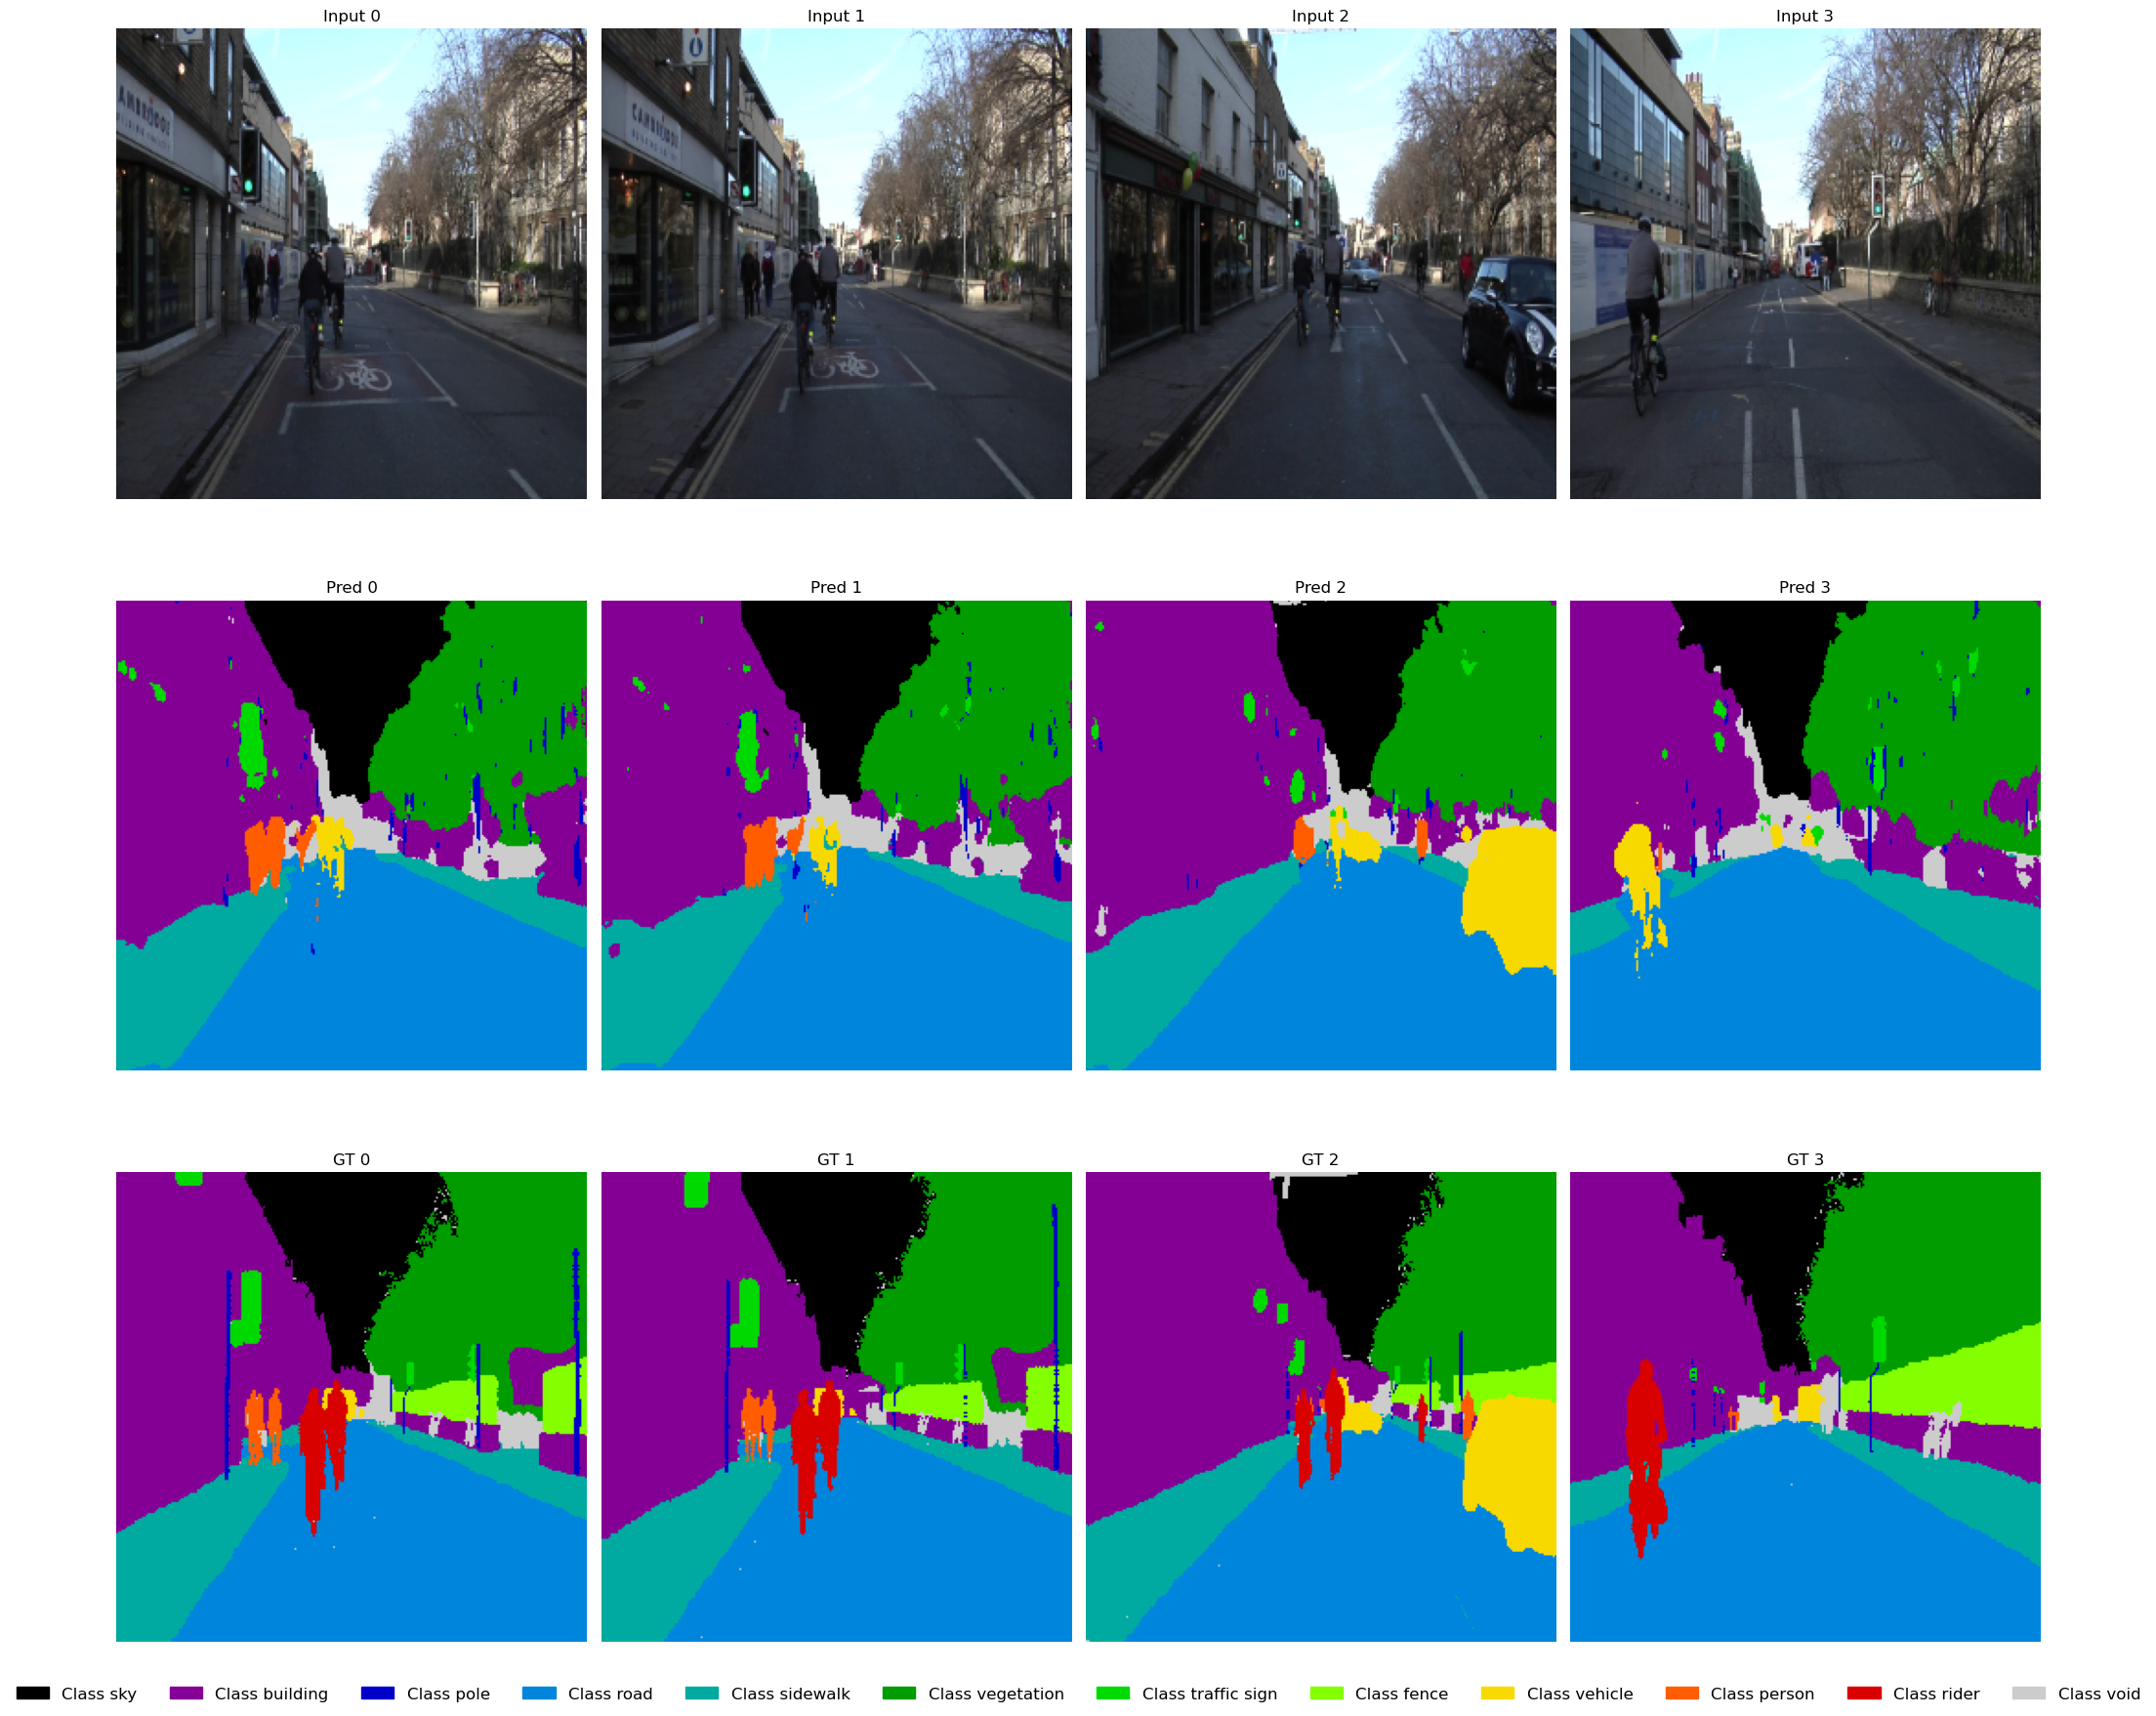

In [114]:
from architecture import UNET
import torch
from PIL import Image

model = UNET(in_channels=3, out_channels=len(labels_df))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
state_dict = torch.load(os.path.join(MODEL_PATH, 'best_model_dice.pth'), weights_only=True)
missing, unexpected = model.load_state_dict(state_dict)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Usage with DataLoader
model.eval()
with torch.no_grad():
    for images, masks in test_dataloader:
        # Verify shapes
        print("Input shape:", images.shape)  # Should be [B,C,H,W]
        print("Mask shape:", masks.shape)   # Should be [B,H,W]
        
        # Run inference
        logits, probs, preds = inference(images, model)
        iou_score = calculate_iou_scores(masks, preds)
        # Verify output shapes
        print("Logits shape:", logits.shape)  # Should be [B,C,H,W]
        print("Preds shape:", preds.shape)    # Should be [B,H,W]
        print(f"IOU score: {iou_score}")
        print(f"IOU score mean: {np.mean(iou_score)}")
        dice_score = calculate_dice_coefficients(masks, preds)
        print(f"Dice Coef score: {iou_score}")
        print(f"Dice Coef score mean: {np.mean(iou_score)}")
        
        # Visualize
        visualize_results(images, preds, masks, labels_df)
        
        break  # Only show first batch

Missing keys: []
Unexpected keys: []
Input shape: torch.Size([32, 3, 256, 256])
Mask shape: torch.Size([32, 256, 256])
Logits shape: torch.Size([32, 12, 256, 256])
Preds shape: torch.Size([32, 256, 256])
IOU score: [0.99577121 0.9935335  0.99277978 0.99472862 0.992835   0.99125851
 0.99469407 0.99057207 0.99340292 0.99174323 0.99333544 0.99412481
 0.99176323 0.99514467 0.99466081 0.99151351 0.99281321 0.99251346
 0.9938488  0.99500426 0.99458648 0.99494313 0.99476157 0.99517243
 0.99419422 0.98981728 0.99270048 0.99558683 0.99346524 0.9913936
 0.9916675  0.98947698]
IOU score mean: 0.9932439645407904
Dice Coef score: [0.99577121 0.9935335  0.99277978 0.99472862 0.992835   0.99125851
 0.99469407 0.99057207 0.99340292 0.99174323 0.99333544 0.99412481
 0.99176323 0.99514467 0.99466081 0.99151351 0.99281321 0.99251346
 0.9938488  0.99500426 0.99458648 0.99494313 0.99476157 0.99517243
 0.99419422 0.98981728 0.99270048 0.99558683 0.99346524 0.9913936
 0.9916675  0.98947698]
Dice Coef score m

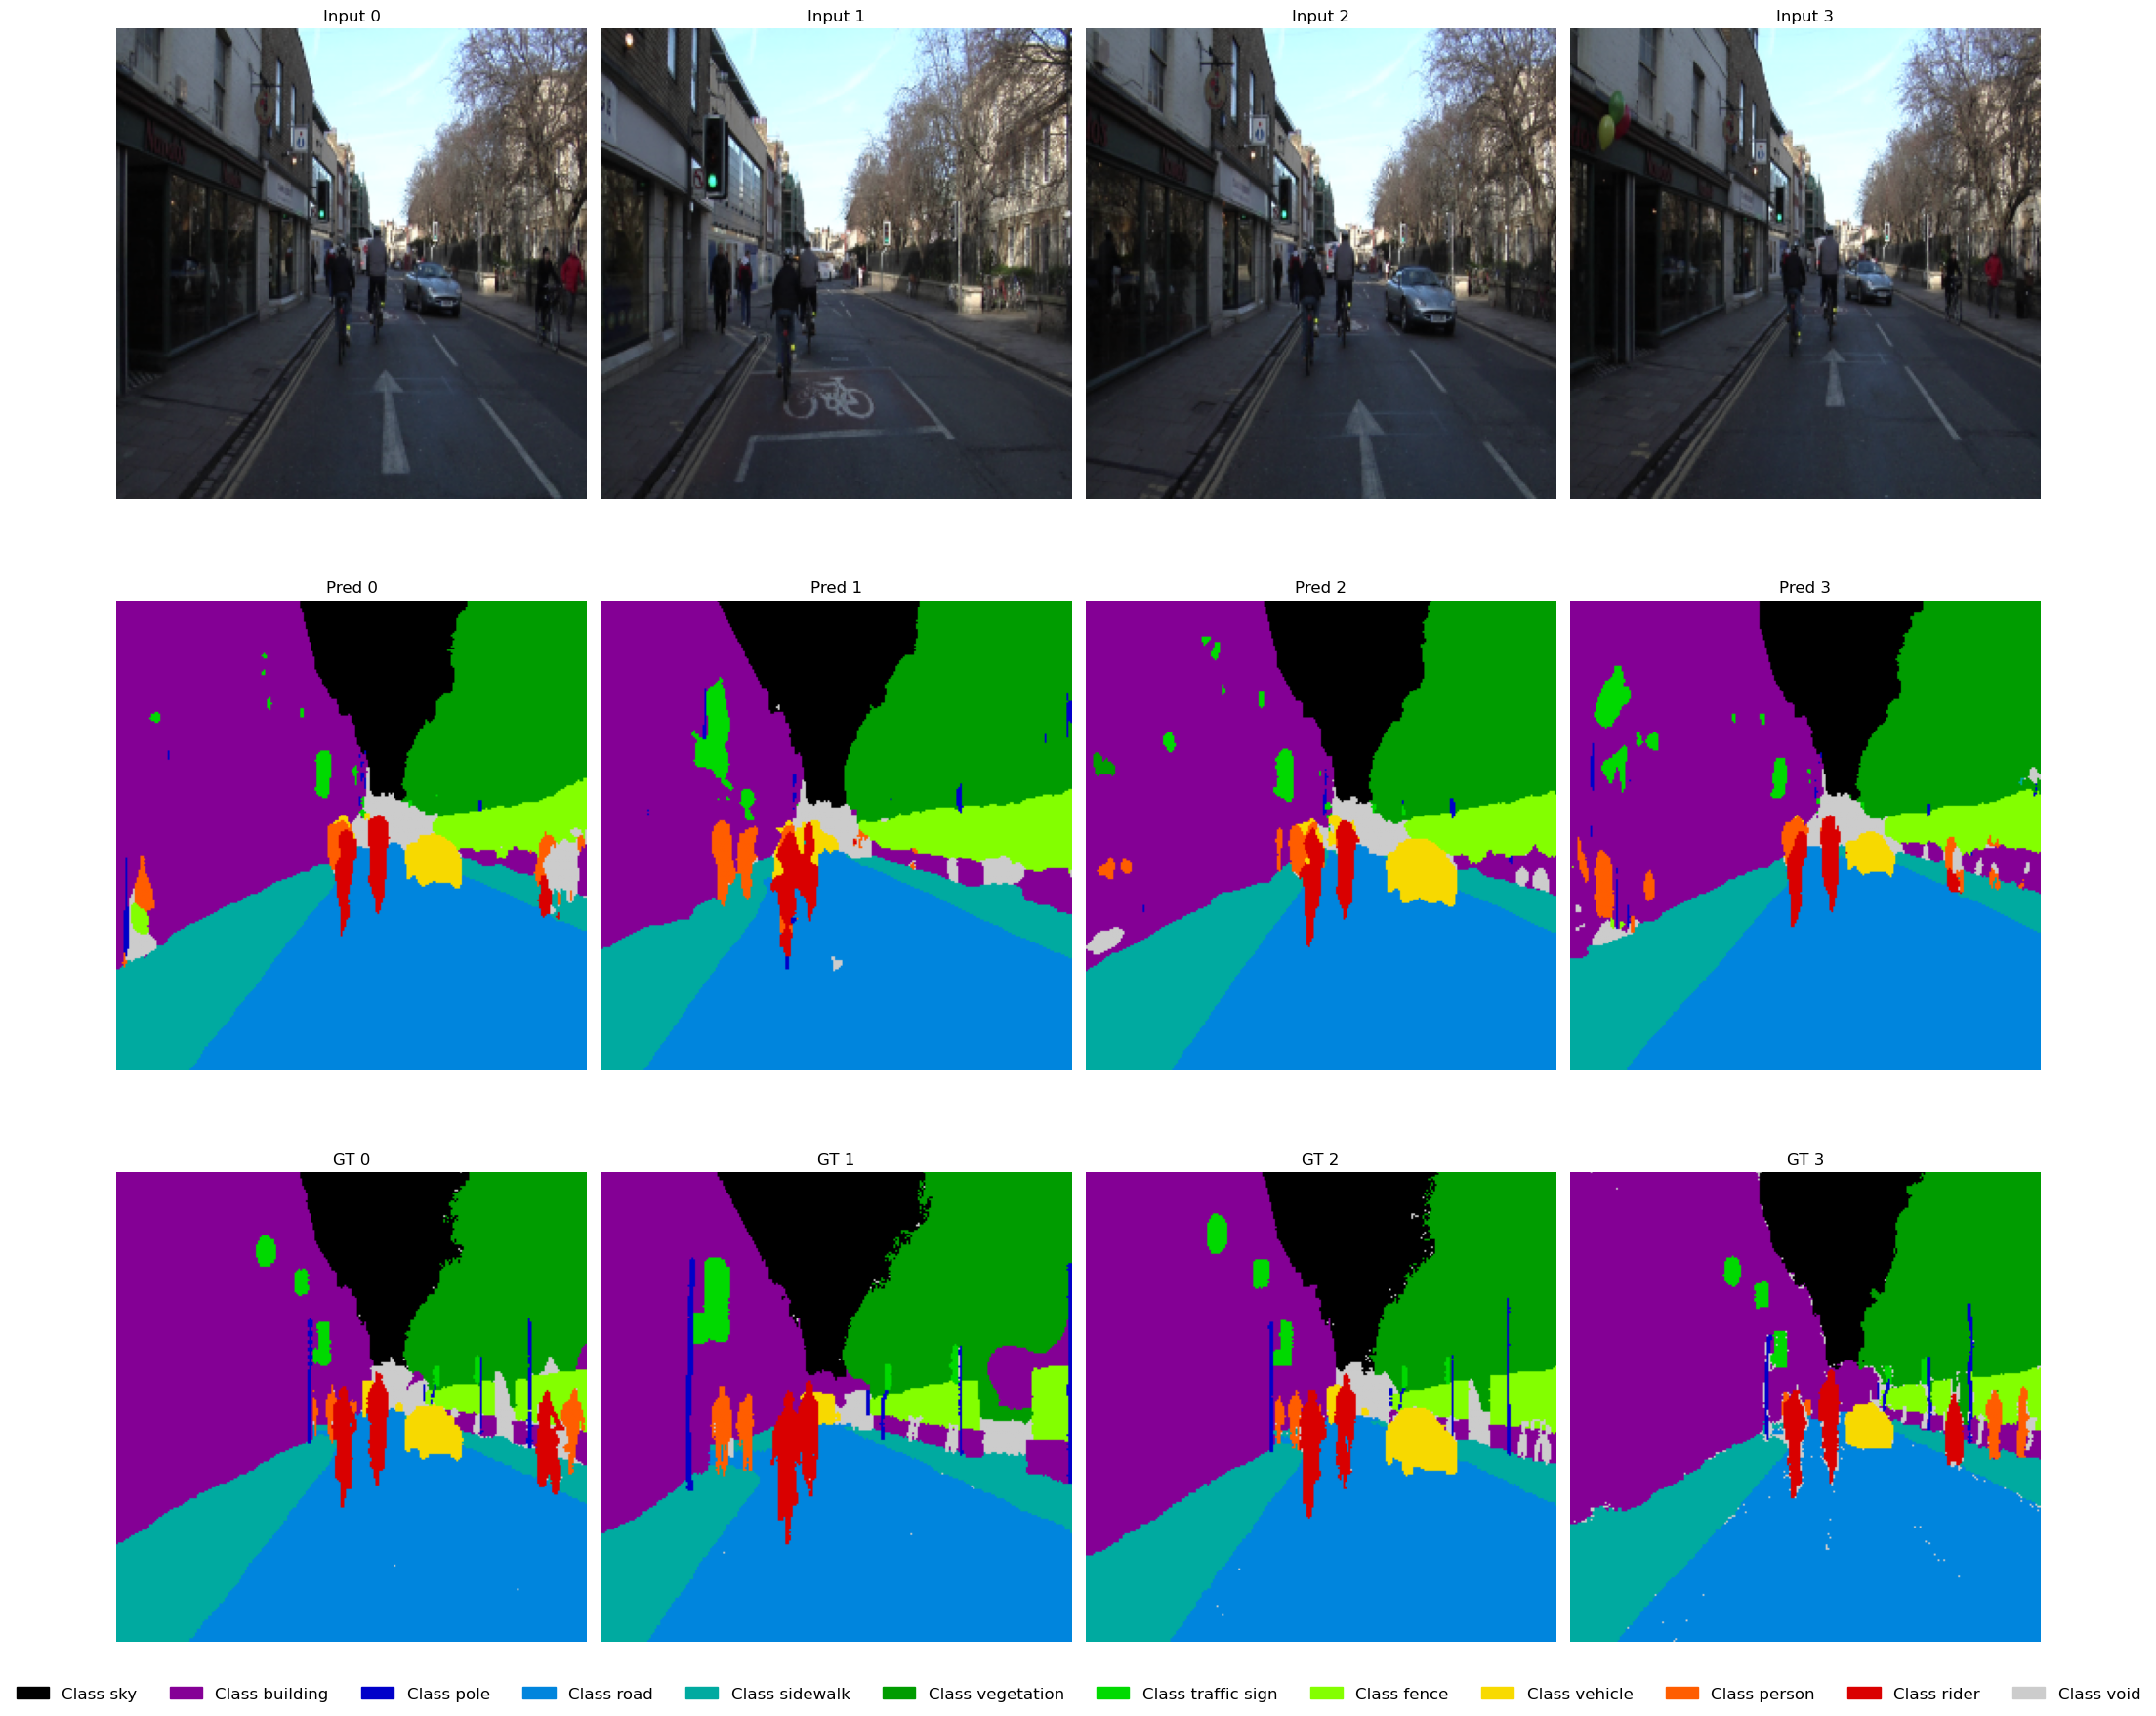

In [115]:
model = UNET(in_channels=3, out_channels=len(labels_df))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
state_dict = torch.load(os.path.join(MODEL_PATH, 'best_model_cross.pth'), weights_only=True)
missing, unexpected = model.load_state_dict(state_dict)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Usage with DataLoader
model.eval()
with torch.no_grad():
    for images, masks in test_dataloader:
        # Verify shapes
        print("Input shape:", images.shape)  # Should be [B,C,H,W]
        print("Mask shape:", masks.shape)   # Should be [B,H,W]
        
        # Run inference
        logits, probs, preds = inference(images, model)
        iou_score = calculate_iou_scores(masks, preds)
        # Verify output shapes
        print("Logits shape:", logits.shape)  # Should be [B,C,H,W]
        print("Preds shape:", preds.shape)    # Should be [B,H,W]
        print(f"IOU score: {iou_score}")
        print(f"IOU score mean: {np.mean(iou_score)}")
        dice_score = calculate_dice_coefficients(masks, preds)
        print(f"Dice Coef score: {iou_score}")
        print(f"Dice Coef score mean: {np.mean(iou_score)}")
        
        # Visualize
        visualize_results(images, preds, masks, labels_df)
        
        break  # Only show first batch

Missing keys: []
Unexpected keys: []
Input shape: torch.Size([32, 3, 256, 256])
Mask shape: torch.Size([32, 256, 256])
masks:
tensor([[[1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         ...,
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]],

        [[1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         ...,
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3]],

        [[1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         ...,
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3]],

        ...,

        [[1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         ...,
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 

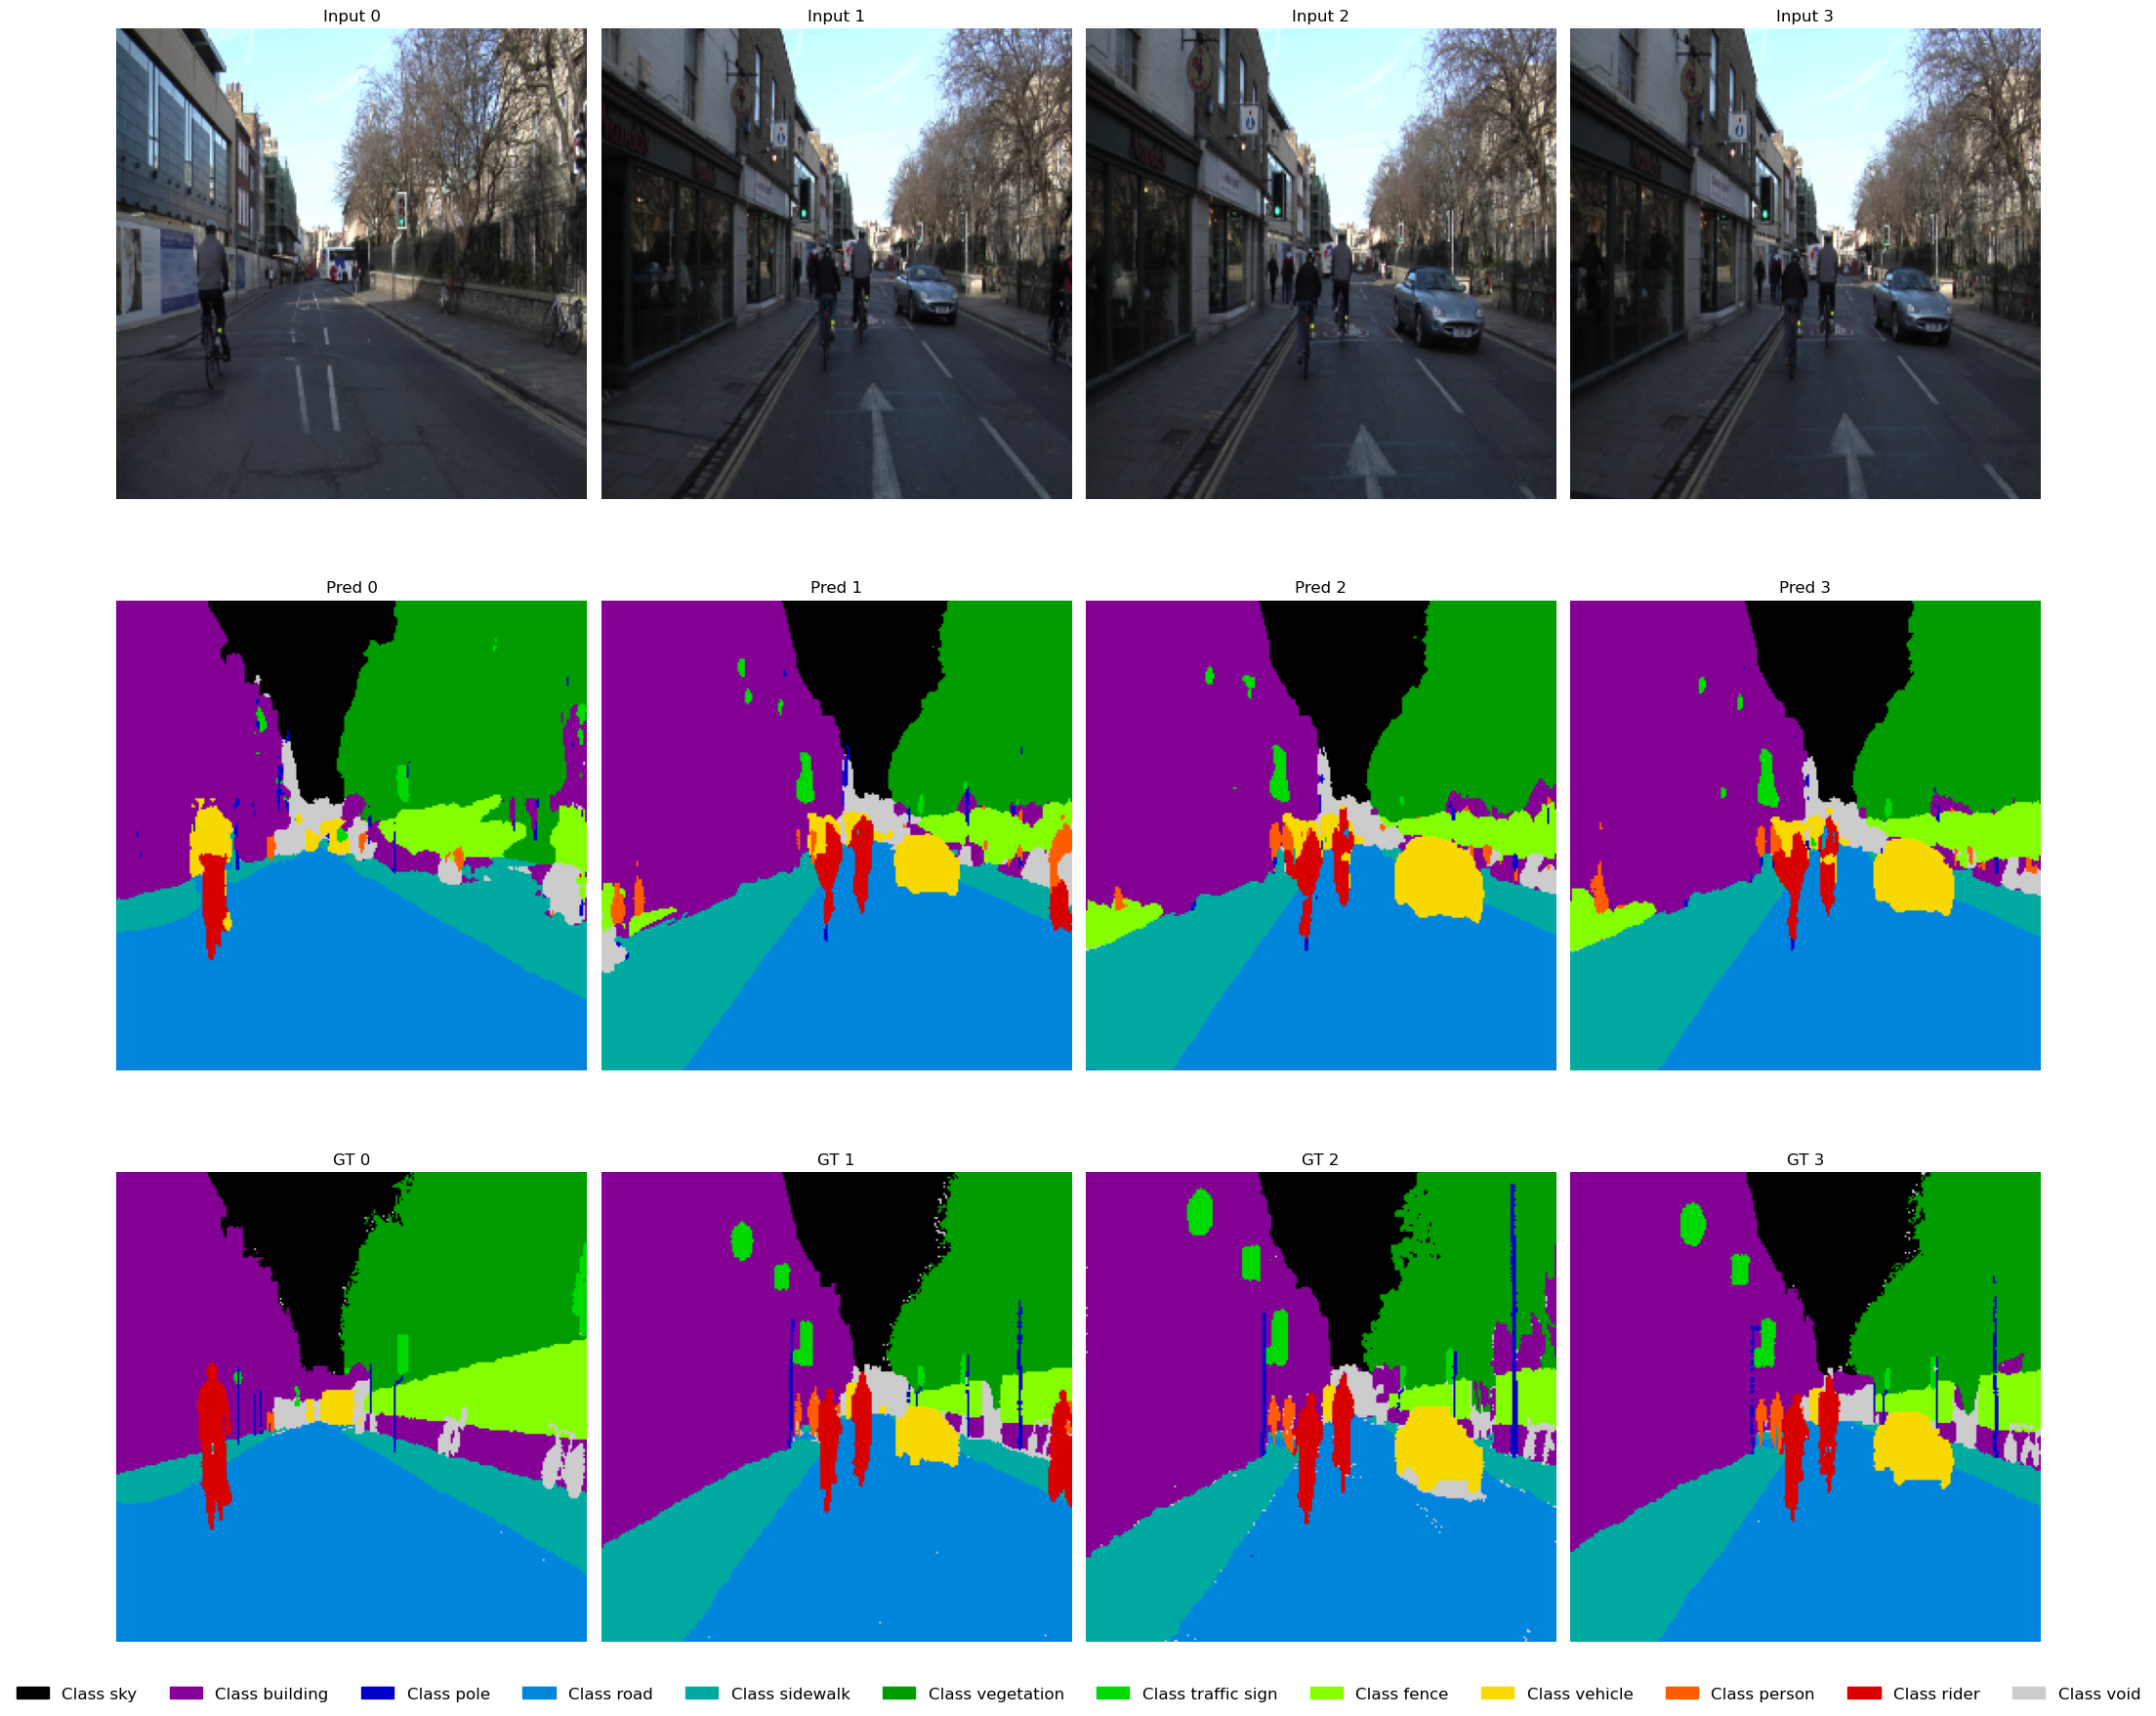

In [117]:
model = UNET(in_channels=3, out_channels=len(labels_df))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
state_dict = torch.load(os.path.join(MODEL_PATH, 'best_model_combined.pth'), weights_only=True)
missing, unexpected = model.load_state_dict(state_dict)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Usage with DataLoader
model.eval()
with torch.no_grad():
    for images, masks in test_dataloader:
        # Verify shapes
        print("Input shape:", images.shape)  # Should be [B,C,H,W]
        print("Mask shape:", masks.shape)   # Should be [B,H,W]
        
        # Run inference
        logits, probs, preds = inference(images, model)
        iou_score = calculate_iou_scores(masks, preds)
        print('masks:')
        print(masks)
        print()
        print('preds: ')
        print(preds)
        # Verify output shapes
        print("Logits shape:", logits.shape)  # Should be [B,C,H,W]
        print("Preds shape:", preds.shape)    # Should be [B,H,W]
        print(f"IOU score: {iou_score}")
        print(f"IOU score mean: {np.mean(iou_score)}")
        dice_score = calculate_dice_coefficients(masks, preds)
        print(f"Dice Coef score: {iou_score}")
        print(f"Dice Coef score mean: {np.mean(iou_score)}")
        
        # Visualize
        visualize_results(images, preds, masks, labels_df)
        
        break  # Only show first batch

Missing keys: []
Unexpected keys: []
Input shape: torch.Size([32, 3, 256, 256])
Mask shape: torch.Size([32, 256, 256])
masks:
tensor([[[1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         ...,
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3]],

        [[1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         ...,
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]],

        [[1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         ...,
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]],

        ...,

        [[1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         ...,
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 

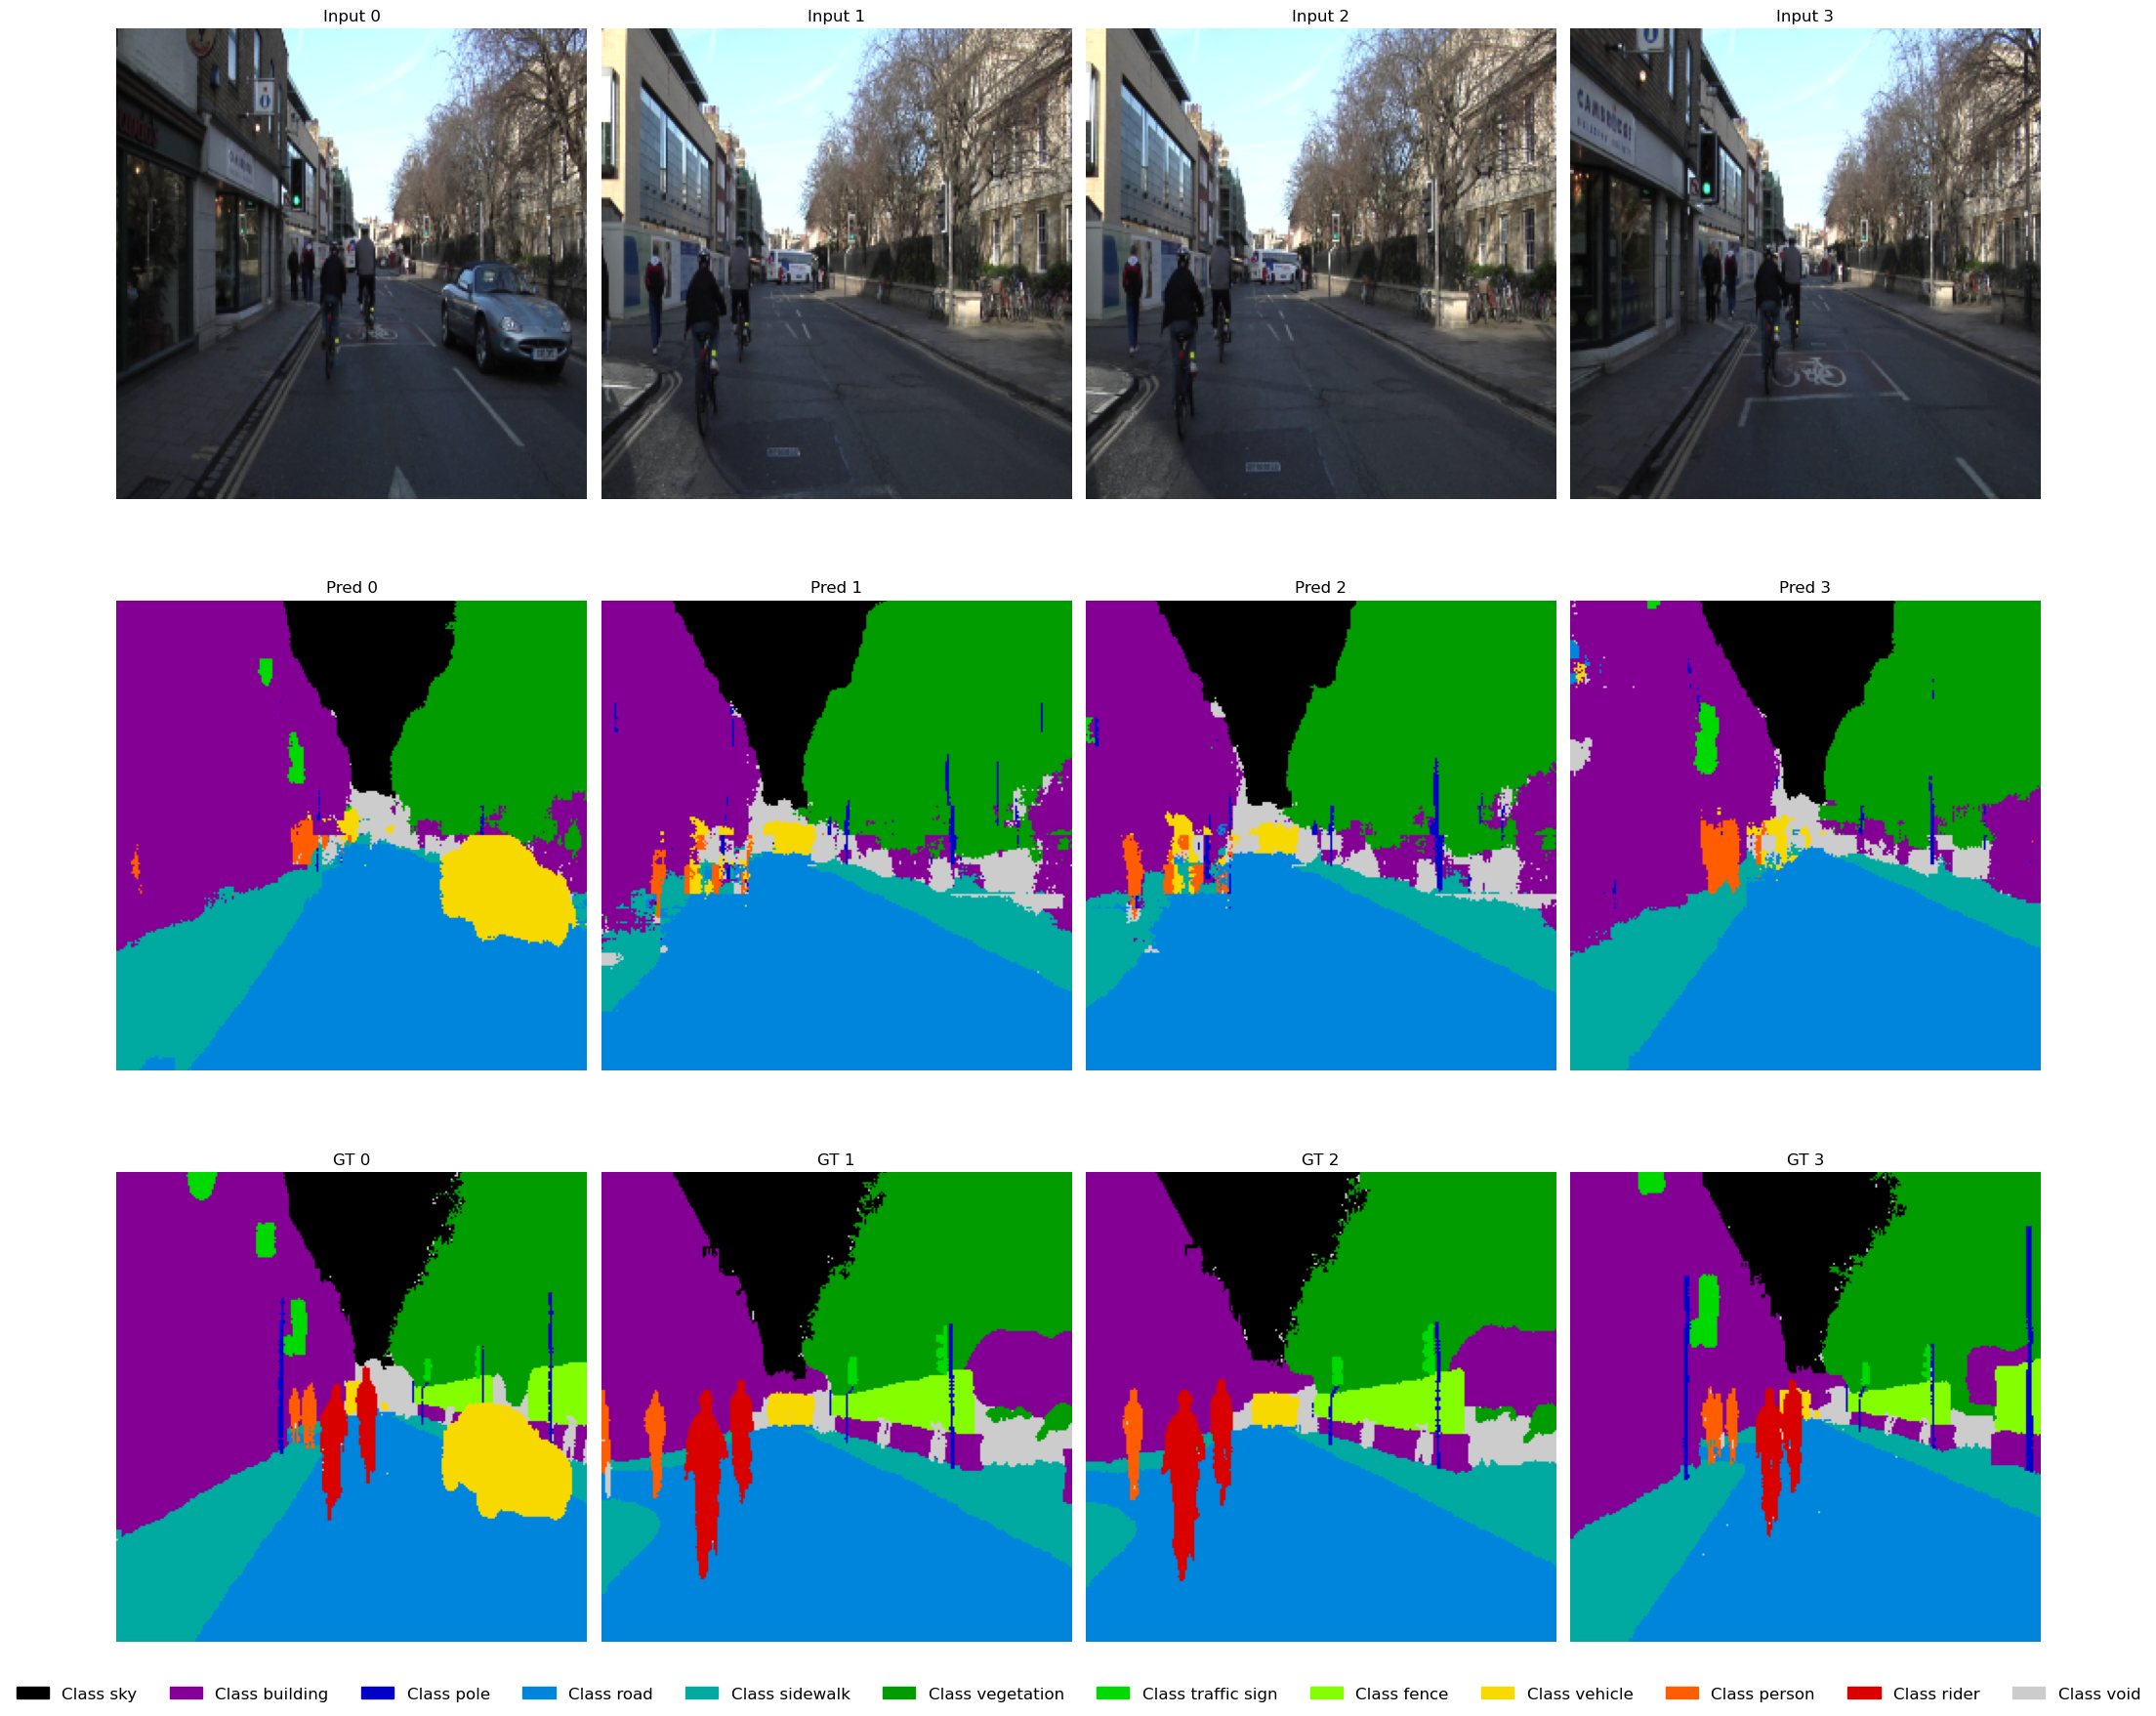

In [8]:
from architecture import FCN8s
import torch

model = FCN8s(in_channels=3, out_channels=len(labels_df))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
state_dict = torch.load(os.path.join(MODEL_PATH_FCN8S, 'best_model_dice.pth'), weights_only=True)
missing, unexpected = model.load_state_dict(state_dict)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Usage with DataLoader
model.eval()
with torch.no_grad():
    for images, masks in test_dataloader:
        # Verify shapes
        print("Input shape:", images.shape)  # Should be [B,C,H,W]
        print("Mask shape:", masks.shape)   # Should be [B,H,W]
        
        # Run inference
        logits, probs, preds = inference(images, model)
        iou_score = calculate_iou_scores(masks, preds)
        print('masks:')
        print(masks)
        print()
        print('preds: ')
        print(preds)
        # Verify output shapes
        print("Logits shape:", logits.shape)  # Should be [B,C,H,W]
        print("Preds shape:", preds.shape)    # Should be [B,H,W]
        print(f"IOU score: {iou_score}")
        print(f"IOU score mean: {np.mean(iou_score)}")
        dice_score = calculate_dice_coefficients(masks, preds)
        print(f"Dice Coef score: {iou_score}")
        print(f"Dice Coef score mean: {np.mean(iou_score)}")
        
        # Visualize
        visualize_results(images, preds, masks, labels_df)
        
        break  # Only show first batch